In [1]:
import matplotlib.pyplot as plt
import numpy as np
import qt_trajectories as qtr

#plt.rcParams['text.usetex'] = True
#plt.rcParams.update({'font.size': 18})
#plt.rcParams['figure.figsize'] = [10,5]

%load_ext autotime
%load_ext line_profiler

In [2]:
# In this notebook we reproduce the results given in:
# Daryanoosh and Wiseman, 2015, 10.1103/PhysRevA.92.042114

##Pauli matrices
s_x=np.array([[0.,1.],[1.,0.]], dtype=np.complex128)
s_y=np.array([[0.,-1j],[1j,0.]], dtype=np.complex128)
s_z=np.array([[1.,0.],[0.,-1.]], dtype=np.complex128)

time: 958 µs


In [3]:
###SYSTEM###

## Parameters 
gamma = 1

## Time range
t0 = 0.
tf = 10
time_steps = 2500
dt = abs(tf-t0)/time_steps
t = np.linspace(t0, tf, np.int32(time_steps))

## Initial state 
psi0 = 1/np.sqrt(2) * np.array([1.,1.], dtype=np.complex128)

## Hamiltonian
def H0(t):
    return np.array([[0.,0.],[0.,0.]], dtype=np.complex128)

## Lindblad operators
def L(t):
    return [np.sqrt(gamma)*s_z]

time: 3.1 ms


In [4]:
eta0 = 0.1
etaf = 0.9
eta_vec = np.linspace(eta0, etaf, num = 9)

time: 1.49 ms


In [29]:
n_traj = 3000

SII_vec = []
EX_vec = []
EY_vec = []
eta = 0.1

N = 1
Mu_vec =  np.linspace(0.1,1,N)
time_steps = 1000*np.linspace(1,2,N)
counter = 0
for mu in Mu_vec:
    dt = abs(tf-t0)/np.int32(time_steps[counter])
    t = np.linspace(t0, tf, np.int32(time_steps[counter]))
    nu = eta
    u_1 = nu * np.matrix([1.])   #X-homodyne
    u_2 = nu * np.matrix([-1.])  #Y-homodyne
    h = eta * np.eye(len(L(0)))

    ## Expectation values 
    EX = np.zeros(len(t))
    EY = np.zeros(len(t))
    EXII = np.zeros(len(t))
    EYII = np.zeros(len(t))
    SII = np.zeros(len(t))
    
    ## Class objects
    systemX = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_1, HMatrix = h, amp = [mu, mu])
    systemY = qtr.System(H0, psi0, t, lindbladList = L, uMatrix = u_2, HMatrix = h, amp = [mu, mu])

    for n_trajectories in 300*np.ones(10):
        ## X Trajectories ensemble
        #X_ensemble = systemX.jumpRhoEnsemble(int(n_trajectories), traj_type = 'density_matrix', time_dep = False, unraveling = True)   
        X_ensemble = systemX.diffusiveRhoEnsemble(int(n_trajectories))   
        for n in range(int(n_trajectories)):
            X_bloch = qtr.rhoBlochrep_data(X_ensemble[n])
            for i in range(len(t)):
                EXII[i] += X_bloch[2][i]**2
                EX[i] += X_bloch[0][i]**2 + X_bloch[1][i]**2
        del X_ensemble
        del X_bloch

        ## Y Trajectories ensemble
        #Y_ensemble = systemY.jumpRhoEnsemble(int(n_trajectories), traj_type = 'density_matrix', time_dep = False, unraveling = True)
        Y_ensemble = systemY.diffusiveRhoEnsemble(int(n_trajectories)) 
        for n in range(int(n_trajectories)):
            Y_bloch = qtr.rhoBlochrep_data(Y_ensemble[n])
            for i in range(len(t)):
                EYII[i] += Y_bloch[0][i]**2 + Y_bloch[1][i]**2
                EY[i] += Y_bloch[0][i]**2 + Y_bloch[1][i]**2
        del Y_ensemble
        del Y_bloch
    
    EX = EX/n_traj
    EY = EY/n_traj
    EXII = EXII/n_traj
    EYII = EYII/n_traj

    #FIG 4
    for i in range(len(t)):
        SII[i] = EYII[i] + EXII[i]
    SII_vec.append(SII)
    EX_vec.append(EX)
    EY_vec.append(EY)
    counter += 1

time: 9min 42s


In [30]:
np.save('data_eta_01_inf.npy', np.array([t, SII_vec, EX_vec, EY_vec], dtype = object))

time: 6.46 ms


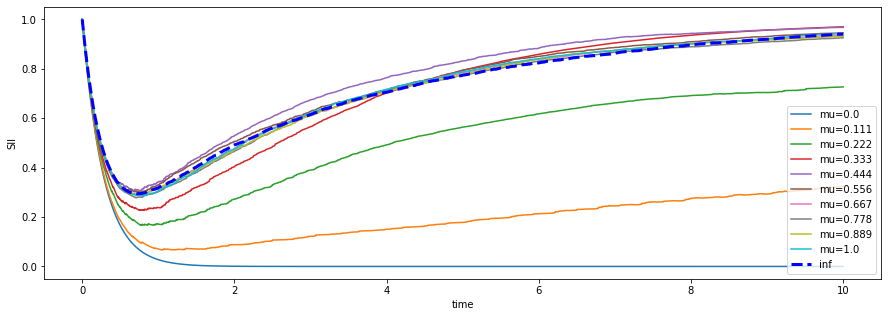

time: 418 ms


In [31]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=15, h=5)

data_ = np.load('data_eta_0_1.npy',allow_pickle=True)
data = np.load('data_eta_01_inf.npy',allow_pickle=True)

Mu = np.linspace(0,1,10)

for i in range(0,10):
    ax.plot(data_[0], data_[1][i], label = 'mu=' + str(np.round(Mu[i], 3)))

ax.plot(data[0], data[1][0], label = 'inf', linewidth = 3, linestyle="--", color = 'blue')

plt.legend()
plt.xlabel('time')
plt.ylabel('SII')

plt.show()

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1)
fig.set_size_inches(w=15, h=5)
data = np.load('data_eta_03_inf.npy',allow_pickle=True)

ax.plot(data[0], data[1][0], label = 'inf')

#for i in range(len(Mu_vec)):
for i in range(0,6):
    t = np.linspace(t0, tf, np.int32(time_steps[i]))
    #ax.plot(t, SII_vec[i], label = 'mu=' + str(round(Mu_vec[i], 1)))
plt.legend()
plt.xlabel('time')
plt.ylabel('SII')
plt.show()

In [ ]:
for i in range(len(eta_vec)):
    plt.plot(t, EX_vec[i], label = 'EX')
    plt.plot(t, EY_vec[i], label = 'EY')
    plt.title('FIG4 for eta=' + str(round(eta_vec[5],1)))
    plt.xlabel('time')
    plt.ylabel('E')
    plt.show()